# CCM Final Project
#### Baysian Modeling of Orientation WM prior

### Content
1. Load and Sort data
2. Prior Model Simulate
3. Fit Prior Model
4. Validation of Prior Model (Recover the params from the simulated data)

### 1. Load and Sort Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import pearsonr

In [2]:
curr_dif = os.getcwd()
data_dir = os.path.abspath(os.path.join(curr_dif, '..\\..\\'))
os.listdir(data_dir)

['.Rhistory',
 '.Rproj.user',
 'CCM_finalProject',
 'CCM_Final_23Spring.Rproj',
 'data',
 'data_beh.csv',
 'figures',
 'scripts']

In [3]:
data_path = os.path.join(data_dir,'data_beh.csv')
data = pd.read_csv(data_path,sep=',')

print(data.head())

   subjID  run  trial  phase  oriRef  oriJitt  oriFinal  oriRespInit  \
0       1    1      1      9       2       -9        36           63   
1       1    1      2      3       1       -9       171           85   
2       1    1      3      4       2       -1        44           58   
3       1    1      4      1       3        6        96           12   
4       1    1      5      3       4        3       138           43   

   oriRespFinal  error  points        rt  outoftime  iti  
0            62    -26      48  2.609021        NaN  0.2  
1           165      6      88  3.047162        NaN  0.2  
2            53     -9      82  2.500657        NaN  0.2  
3            99     -3      94  3.697208        NaN  0.2  
4           143     -5      90  3.665645        NaN  0.2  


In [4]:
data_df = pd.DataFrame(data)
flag = data_df['outoftime']!=1
print(sum(flag))
data_clean = data_df[flag]
# Kay: some additional cleaning and recoding
data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
data_clean['oriRespFinal2'] = data_clean['oriFinal2'] - data_clean['error']
data_clean['oriFinal3'] = data_clean['oriJitt']
data_clean['oriRespFinal3'] = data_clean['oriRespFinal2'] - data_clean['oriRef2']
data_clean = data_clean[data_clean['error'].abs() < 22.55]
data_clean

2319


C:\Users\kay\AppData\Local\Temp\ipykernel_4576\447142464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
C:\Users\kay\AppData\Local\Temp\ipykernel_4576\447142464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
C:\Users\kay\AppData\Local\Temp\ipykernel_4576\447142464.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,subjID,run,trial,phase,oriRef,oriJitt,oriFinal,oriRespInit,oriRespFinal,error,points,rt,outoftime,iti,oriRef2,oriFinal2,oriRespFinal2,oriFinal3,oriRespFinal3
1,1,1,2,3,1,-9,171,85,165,6,88,3.047162,NaN,0.2,0,-9,-15,-9,-15
2,1,1,3,4,2,-1,44,58,53,-9,82,2.500657,NaN,0.2,45,44,53,-1,8
3,1,1,4,1,3,6,96,12,99,-3,94,3.697208,NaN,0.2,90,96,99,6,9
4,1,1,5,3,4,3,138,43,143,-5,90,3.665645,NaN,0.2,135,138,143,3,8
5,1,1,6,7,1,-9,171,152,164,7,86,1.547777,NaN,0.2,0,-9,-16,-9,-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,15,1,155,7,3,-1,89,93,88,1,98,2.375790,NaN,0.2,90,89,88,-1,-2
2395,15,1,156,1,3,0,90,18,91,-1,98,2.757365,NaN,0.2,90,90,91,0,1
2397,15,1,158,5,4,1,136,149,127,9,82,2.387765,NaN,0.2,135,136,127,1,-8
2398,15,1,159,2,2,-6,39,20,46,-7,86,1.181797,NaN,0.2,45,39,46,-6,1


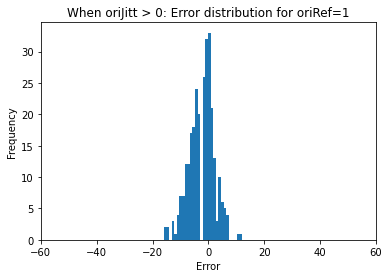

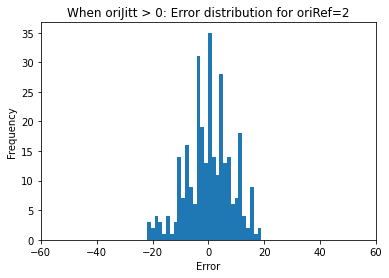

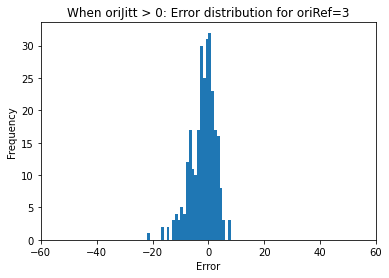

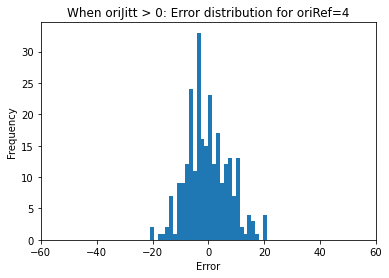

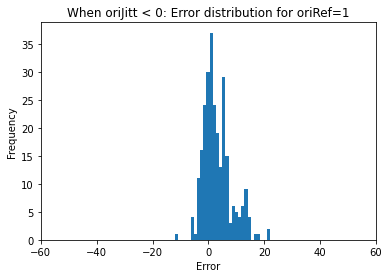

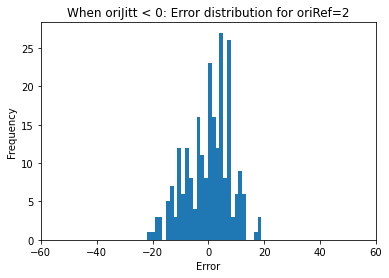

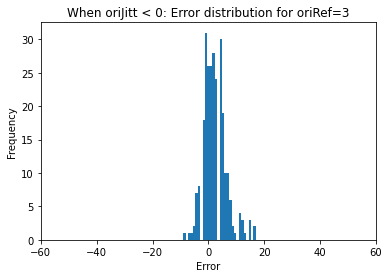

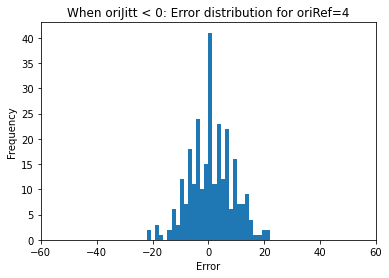

In [5]:
oriRefs = np.unique(data_clean['oriRef'])
data_clean_pos = data_clean[data_clean['oriJitt'] > 0]


for oriRef in oriRefs:
    data_oriRef = data_clean_pos[data_clean_pos['oriRef'] == oriRef]
    plt.hist(data_oriRef['error'], bins=30)
    plt.xlim(-60, 60)
    plt.title(f'When oriJitt > 0: Error distribution for oriRef={oriRef}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()
    
# Kay: an visualization
oriRefs = np.unique(data_clean['oriRef'])
data_clean_neg = data_clean[data_clean['oriJitt'] < 0]


for oriRef in oriRefs:
    data_oriRef = data_clean_neg[data_clean_neg['oriRef'] == oriRef]
    plt.hist(data_oriRef['error'], bins=30)
    plt.xlim(-60, 60)
    plt.title(f'When oriJitt < 0: Error distribution for oriRef={oriRef}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

### 2. Modelling

In [6]:
data_ref2 = data_clean[data_clean['oriRef2'] == 45]
subject1_ref2 = data_ref2[data_ref2['subjID']== 1]
targ_loc_s1r2 = np.array(subject1_ref2['oriFinal3'])
real_response_s1r2 = np.array(subject1_ref2['oriRespFinal3'])

In [7]:
def prior_nll(targ_loc,true_answer, prior_std, likelihood_std):
    ntrials = targ_loc.shape[0]
    xs = np.linspace(-90, 90, 181)
    prior_mu = 0
    log_prior = norm.logpdf(xs, loc=prior_mu, scale=prior_std)
    log_prior = np.tile(log_prior, (ntrials, 1))
    log_likelihood = norm.logpdf(xs.reshape(1, -1), loc=targ_loc[:, np.newaxis], scale=likelihood_std)
    log_post_unnormalized = log_likelihood + log_prior
    normalizing_factor = np.tile(logsumexp(log_post_unnormalized, axis =1), (len(xs), 1)).T
    log_post = log_post_unnormalized - normalizing_factor
    nll = -log_post
    nLL = []
    for i in range(0,len(true_answer)):
        trial_true = (true_answer[i] + 90).astype(int)
        trail_nll = nll[i, :]
        trail_nLL = trail_nll[trial_true]
        nLL.append(trail_nLL)
    return np.sum(np.array(nLL))

In [8]:
prior_nll(targ_loc_s1r2,real_response_s1r2, 10, 10)

158.70055140083105

In [9]:
def non_prior_nll(targ_loc,true_answer, likelihood_std):
    ntrials = targ_loc.shape[0]
    xs = np.linspace(-90, 90, 181)
    log_likelihood = norm.logpdf(xs.reshape(1, -1), loc=targ_loc[:, np.newaxis], scale=likelihood_std)
    log_post_unnormalized = log_likelihood
    normalizing_factor = np.tile(logsumexp(log_post_unnormalized, axis =1), (len(xs), 1)).T
    log_post = log_post_unnormalized - normalizing_factor
    nll = -log_post
    nLL = []
    for i in range(0,len(true_answer)):
        trial_true = (true_answer[i] + 90).astype(int)
        trail_nll = nll[i, :]
        trail_nLL = trail_nll[trial_true]
        nLL.append(trail_nLL)
    return np.sum(np.array(nLL))

In [10]:
non_prior_nll(targ_loc_s1r2,real_response_s1r2, 10)

143.13942142175

In [11]:
def wrapped_prior_nll(params, targ_loc, true_answer):
    prior_std, likelihood_std = params
    return prior_nll(targ_loc,true_answer, prior_std, likelihood_std)

init_guess_prior = [10, 20]  # [prior_std_guess, likelihood_std_guess]

In [12]:
result_prior_s1r2 = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(targ_loc_s1r2, real_response_s1r2), bounds=((1e-5, 500), (1e-5, 100)))
op_prior_std_s1r2, op_prior_likelihood_std_s1r2 = result_prior_s1r2.x

print("Optimized nll (with prior):", prior_nll(targ_loc_s1r2,real_response_s1r2, op_prior_std_s1r2, op_prior_likelihood_std_s1r2))
print("Optimized prior_std:", op_prior_std_s1r2)
print("Optimized likelihood_std (with prior):", op_prior_likelihood_std_s1r2)

Optimized nll (with prior): 143.03249352280747
Optimized prior_std: 500.0
Optimized likelihood_std (with prior): 9.475012744682704


In [13]:
def wrapped_non_prior_nll(params, targ_loc, true_answer):
    likelihood_std = params
    return non_prior_nll(targ_loc,true_answer, likelihood_std)

init_guess_non_prior = [10]  # [likelihood_std_guess]

In [14]:
result_no_prior_s1r2 = minimize(wrapped_non_prior_nll, init_guess_non_prior, 
                                   args=(targ_loc_s1r2, real_response_s1r2), bounds=((1e-5, 500),))
op_nonprior_likelihood_std_s1r2 = result_no_prior_s1r2.x[0]

print("Optimized nll(without prior):", non_prior_nll(targ_loc_s1r2,real_response_s1r2, op_nonprior_likelihood_std_s1r2))
print("Optimized likelihood_std (without prior):", op_nonprior_likelihood_std_s1r2)

Optimized nll(without prior): 143.02925652129034
Optimized likelihood_std (without prior): 9.473316893417504


### 3. Validation of Model (Recover the params from the simulated data)

In [15]:
def generate_synthetic_data_prior(n_samples, prior_mu, prior_std, likelihood_std):
    xs = np.linspace(-90, 90, 181)
    targ_loc = []
    real_response = []
    prior = norm.pdf(xs, loc= prior_mu, scale = prior_std)
    for i in range(0, n_samples):
        targ_loc_i = np.round(np.random.normal(loc=prior_mu, scale = prior_std, size = 1))
        likelihood_i = norm.pdf(xs, loc= targ_loc_i, scale = likelihood_std)
        post_i = prior * likelihood_i
        post_i = post_i/np.sum(post_i)
        real_response_i = np.random.choice(xs, p =post_i)
        targ_loc.append(targ_loc_i)
        real_response.append(real_response_i)
    return np.array(targ_loc).flatten(), np.array(real_response)

n_samples = 1000
prior_mu = 0
prior_std_sim = 5
likelihood_std_sim = 30

targ_loc_sim, true_answer_sim = generate_synthetic_data_prior(n_samples, prior_mu, prior_std_sim, likelihood_std_sim)

In [16]:
result_prior_synthetic = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(targ_loc_sim, true_answer_sim), bounds=((1e-5, 500), (1e-5, 500)))
recovered_prior_std, recovered_prior_likelihood_std = result_prior_synthetic.x

print("Original nll (with prior):", prior_nll(targ_loc_sim, true_answer_sim, prior_std_sim, likelihood_std_sim))
print("Optimized nll (with prior):", prior_nll(targ_loc_sim, true_answer_sim, recovered_prior_std, recovered_prior_likelihood_std))
print("True prior_std:", prior_std_sim)
print("Recovered prior_std (with prior):", recovered_prior_std)
print("True likelihood_std (with prior):", likelihood_std_sim)
print("Recovered likelihood_std (with prior):", recovered_prior_likelihood_std)

Original nll (with prior): 3036.797919505677
Optimized nll (with prior): 3036.2158012055406
True prior_std: 5
Recovered prior_std (with prior): 5.071099834587395
True likelihood_std (with prior): 30
Recovered likelihood_std (with prior): 45.10279381074607


In [17]:
result_no_prior_synthetic = minimize(wrapped_non_prior_nll, init_guess_non_prior, 
                                   args=(targ_loc_sim, true_answer_sim), bounds=((1e-5, 500),))
recovered_no_prior_likelihood_std = result_no_prior_synthetic.x[0]

print("Original nll (with prior):", prior_nll(targ_loc_sim, true_answer_sim, prior_std_sim, likelihood_std_sim))
print("Optimized nll (without prior):", non_prior_nll(targ_loc_sim, true_answer_sim, recovered_no_prior_likelihood_std))
print("True prior_std:", prior_std_sim)
print("Recovered prior_std (with prior):", "no prior proposed")
print("True likelihood_std (with prior):", likelihood_std_sim)
print("Recovered likelihood_std (without prior):", recovered_no_prior_likelihood_std)

Original nll (with prior): 3036.797919505677
Optimized nll (without prior): 3377.4239057807636
True prior_std: 5
Recovered prior_std (with prior): no prior proposed
True likelihood_std (with prior): 30
Recovered likelihood_std (without prior): 7.088583965842733


In [18]:
# Calculate NLL for both models using optimal parameters
nll_prior = prior_nll(targ_loc_sim, true_answer_sim, recovered_prior_std, recovered_prior_likelihood_std)
nll_non_prior = non_prior_nll(targ_loc_sim, true_answer_sim, recovered_no_prior_likelihood_std)

# Calculate the number of parameters (k) for each model
k_prior = 2  # prior_std and likelihood_std
k_non_prior = 1  # likelihood_std

# Calculate AIC for each model
aic_prior = 2 * 2 + 2 * nll_prior
aic_non_prior = 2 * 1 + 2 * nll_non_prior

# Calculate BIC for each model
# Calculate the number of samples (n)
n_samples = targ_loc_sim.shape[0]
bic_prior = 2 * np.log(n_samples) + 2 * nll_prior
bic_non_prior = 1 * np.log(n_samples) + 2 * nll_non_prior

print("AIC (prior model):", aic_prior)
print("AIC (non-prior model):", aic_non_prior)
print("BIC (prior model):", bic_prior)
print("BIC (non-prior model):", bic_non_prior)

AIC (prior model): 6076.431602411081
AIC (non-prior model): 6756.847811561527
BIC (prior model): 6086.247112969046
BIC (non-prior model): 6761.755566840509


In [21]:
n_sims = 1000
n_samples = 40
prior_mu = 0

sim_prior_std = []
sim_prior_likelihood_std = []
sim_initial_prior_nll = []

sim_recovered_prior_std = []
sim_recovered_prior_likelihood_std = []
sim_recovered_prior_nll = []
sim_prior_AIC = []
sim_prior_BIC = []

sim_recovered_no_prior_likelihood_std = []
sim_recovered_no_prior_nll = []
sim_no_prior_AIC = []
sim_no_prior_BIC = []

for i in range(0, n_sims):
    
    # Initialize parameters
    i_prior_std = np.random.randint(1, 20, )
    sim_prior_std.append(i_prior_std)
    i_likelihood_std = np.random.randint(1, 20, )
    sim_prior_likelihood_std.append(i_likelihood_std)
    
    # Generate data
    sim_targ_loc, sim_true_answer = generate_synthetic_data_prior(n_samples, prior_mu, i_prior_std, i_likelihood_std)
    sim_initial_prior_nll.append(prior_nll(sim_targ_loc,sim_true_answer, i_prior_std, i_likelihood_std))
    
    # Fit prior model
    init_guess_prior = [np.random.normal(20, 15), np.random.normal(20, 15)]
    sim_result_prior_synthetic = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(sim_targ_loc, sim_true_answer), bounds=((1e-5, 500), (1e-5, 500)))
    i_recovered_prior_std, i_recovered_prior_likelihood_std = sim_result_prior_synthetic.x
    sim_recovered_prior_std.append(i_recovered_prior_std)
    sim_recovered_prior_likelihood_std.append(i_recovered_prior_likelihood_std)
    i_nll_prior = prior_nll(sim_targ_loc,sim_true_answer, i_recovered_prior_std, i_recovered_prior_likelihood_std)
    sim_recovered_prior_nll.append(i_nll_prior)
    i_aic_prior = 2 * 2 + 2 * i_nll_prior
    sim_prior_AIC.append(i_aic_prior)
    i_bic_prior = 2 * np.log(n_samples) + 2 * i_nll_prior
    sim_prior_BIC.append(i_bic_prior)
    
    # Fit non-prior model
    init_guess_no_prior = [np.random.normal(20, 15)]
    sim_result_no_prior_synthetic = minimize(wrapped_non_prior_nll, init_guess_no_prior, 
                                   args=(sim_targ_loc, sim_true_answer), bounds=((1e-5, 500),))
    i_recovered_no_prior_likelihood_std = sim_result_no_prior_synthetic.x[0]
    sim_recovered_no_prior_likelihood_std.append(i_recovered_no_prior_likelihood_std)
    i_nll_no_prior = non_prior_nll(sim_targ_loc,sim_true_answer, i_recovered_no_prior_likelihood_std)
    sim_recovered_no_prior_nll.append(i_nll_no_prior)
    i_aic_no_prior = 2 * 1 + 2 * i_nll_no_prior
    sim_no_prior_AIC.append(i_aic_no_prior)
    i_bic_no_prior = 1 * np.log(n_samples) + 2 * i_nll_no_prior
    sim_no_prior_BIC.append(i_bic_no_prior)

In [22]:
output_dict = {
    'prior_std':sim_prior_std,
    'recovered_prior_std': sim_recovered_prior_std,
    'likelihood_std':sim_prior_likelihood_std,
    'recovered_likelihood_std (with prior)': sim_recovered_prior_likelihood_std,
    'recovered_likelihood_std (without prior)': sim_recovered_no_prior_likelihood_std,
    'initial_nll (with prior)': sim_initial_prior_nll,
    'recovered_nll (with prior)': sim_recovered_prior_nll,
    'recovered_nll (without prior)': sim_recovered_no_prior_nll,
    'AIC (with prior)': sim_prior_AIC,
    'AIC (without prior)': sim_no_prior_AIC,
    'BIC (with prior)': sim_prior_BIC,
    'BIC (without prior)': sim_no_prior_BIC
}

simulation_df = pd.DataFrame(output_dict)
pd.set_option('display.max_rows', None)
simulation_df

,prior_std,recovered_prior_std,likelihood_std,recovered_likelihood_std (with prior),recovered_likelihood_std (without prior),initial_nll (with prior),recovered_nll (with prior),recovered_nll (without prior),AIC (with prior),AIC (without prior),BIC (with prior),BIC (without prior)
0,4,4.048197,6,5.764272,3.830796,104.678271,104.669802,110.480449,213.339605,222.960897,216.717364,224.649777
1,17,13.835031,8,7.693209,7.632176,133.458829,132.982540,138.052423,269.965080,278.104846,273.342839,279.793726
2,6,6.650790,11,8.186724,6.216911,123.102202,122.410928,129.848477,248.821855,261.696954,252.199614,263.385833
3,4,3.263505,17,12.223903,4.626015,104.250288,102.692458,118.025360,209.384916,238.050720,212.762675,239.739599
4,19,18.534730,12,12.204661,11.960462,149.652476,149.626732,156.017306,303.253464,314.034612,306.631223,315.723491
5,14,15.680493,17,13.986965,12.011468,151.341456,150.575093,156.191961,305.150186,314.383921,308.527945,316.072801
6,13,10.091725,5,4.464491,4.598913,113.870169,113.028962,117.790339,230.057923,237.580679,233.435682,239.269558
7,3,2.480480,4,4.809501,3.274905,89.384763,88.378474,104.209091,180.756949,210.418181,184.134707,212.107061
8,6,253.936516,4,4.672484,4.671724,113.521754,118.408836,118.418663,240.817671,238.837327,244.195430,240.526206
9,3,2.544755,15,242.607280,4.104875,95.075653,94.117142,113.244554,192.234285,228.489109,195.612044,230.177988


In [69]:
simulation_df.to_csv('simulation_df.csv', index=False)

In [38]:
simulation_df[(simulation_df['AIC (without prior)'] - simulation_df['AIC (with prior)']) > 2].shape[0]

812

In [37]:
simulation_df[(simulation_df['BIC (without prior)'] - simulation_df['BIC (with prior)']) > 2].shape[0]

758

In [80]:
simulation_df[simulation_df['recovered_prior_std'] < 25].shape[0]

926

Correlation: 0.2004838845974309
P-value: 1.5847684590134316e-10


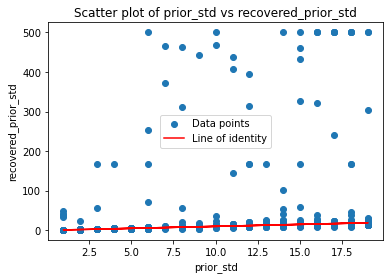

In [79]:
simulation_df1 = simulation_df#[simulation_df['recovered_prior_std'] < 25]
corr, p_value = pearsonr(simulation_df1['prior_std'], simulation_df1['recovered_prior_std'])
print('Correlation:', corr)
print('P-value:', p_value)

x = simulation_df1['prior_std']
y = simulation_df1['recovered_prior_std']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('prior_std')
plt.ylabel('recovered_prior_std')
plt.title('Scatter plot of prior_std vs recovered_prior_std')
plt.legend()
plt.show()

In [81]:
simulation_df[simulation_df['recovered_likelihood_std (with prior)'] < 25].shape[0]

875

Correlation: 0.2513255395381985
P-value: 7.174814989717467e-16


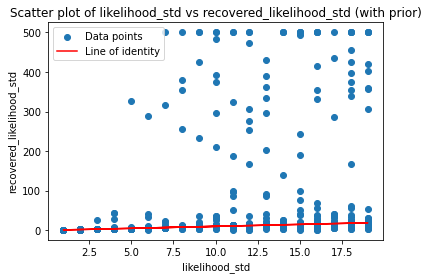

In [82]:
simulation_df2 = simulation_df#[simulation_df['recovered_likelihood_std (with prior)'] < 25]
corr, p_value = pearsonr(simulation_df2['likelihood_std'], simulation_df2['recovered_likelihood_std (with prior)'])
print('Correlation:', corr)
print('P-value:', p_value)

x = simulation_df2['likelihood_std']
y = simulation_df2['recovered_likelihood_std (with prior)']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('likelihood_std')
plt.ylabel('recovered_likelihood_std')
plt.title('Scatter plot of likelihood_std vs recovered_likelihood_std (with prior)')
plt.legend()
plt.show()

In [83]:
simulation_df[simulation_df['recovered_likelihood_std (without prior)'] < 25].shape[0]

1000

Correlation: 0.6413111673669729
P-value: 6.012553830475398e-117


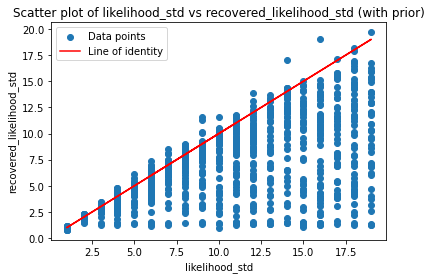

In [84]:
simulation_df3 = simulation_df#[simulation_df['recovered_likelihood_std (without prior)'] < 25]
corr, p_value = pearsonr(simulation_df3['likelihood_std'], simulation_df3['recovered_likelihood_std (without prior)'])
print('Correlation:', corr)
print('P-value:', p_value)

x = simulation_df3['likelihood_std']
y = simulation_df3['recovered_likelihood_std (without prior)']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('likelihood_std')
plt.ylabel('recovered_likelihood_std')
plt.title('Scatter plot of likelihood_std vs recovered_likelihood_std (with prior)')
plt.legend()
plt.show()

### 4. Fit Model to Subject Data

In [19]:
unique_oriRef2 = data_clean['oriRef2'].unique()
unique_SubjID = data_clean['subjID'].unique()
init_guess_prior = [20,10]
init_guess_non_prior = [10]

results = []

for i in unique_SubjID:
    for j in unique_oriRef2:
        subset = data_clean[(data_clean['oriRef2'] == j) & (data_clean['subjID'] == i)]
        targ_loc_sub = np.array(subset['oriFinal3'])
        real_response_sub = np.array(subset['oriRespFinal3'])
        n_samples = targ_loc_sub.shape[0]
        
        # Minimize the negative log-likelihood with prior
        result_prior = minimize(wrapped_prior_nll, init_guess_prior, 
                                args=(targ_loc_sub, real_response_sub), bounds=((1e-5, None), (1e-5, None)))
        estimated_prior_std, estimated_likelihood_std = result_prior.x
        nll_prior = result_prior.fun
        aic_prior = 2 * 2 + 2 * nll_prior
        bic_prior = 2 * np.log(n_samples) + 2 * nll_prior

        # Minimize the negative log-likelihood without prior
        result_no_prior = minimize(wrapped_non_prior_nll, init_guess_non_prior, 
                                   args=(targ_loc_sub, real_response_sub), bounds=((1e-5, None),))
        estimated_likelihood_std_no_prior = result_no_prior.x[0]
        nll_no_prior = result_no_prior.fun
        aic_non_prior = 2 * 1 + 2 * nll_no_prior
        bic_non_prior = 1 * np.log(n_samples) + 2 * nll_no_prior
        
        results.append({
            'subjID': i,
            'oriRef2': j,
            'prior_std': estimated_prior_std,
            'likelihood_std': estimated_likelihood_std,
            'likelihood_std_no_prior': estimated_likelihood_std_no_prior,
            'nll_prior': nll_prior,
            'nll_no_prior': nll_no_prior,
            'AIC (with prior)': aic_prior,
            'AIC (without prior)':aic_non_prior,
            'BIC (with prior)':bic_prior,
            'BIC (without prior)':bic_non_prior
        })

results_df = pd.DataFrame(results)
print(results_df)

    subjID  oriRef2     prior_std  likelihood_std  likelihood_std_no_prior  \
0        1        0   1238.064533        5.742598                 5.742387   
1        1       45   3928.772418        9.473321                 9.473317   
2        1       90   8660.123532        4.806356                 4.806245   
3        1      135   1044.367212        7.302728                 7.302392   
4        2        0    820.551909        5.818188                 5.818075   
5        2       45     17.925921        9.539786                 8.528986   
6        2       90    918.160442        4.207179                 4.207136   
7        2      135     30.673168        7.064511                 6.888397   
8        3        0   2580.820334        5.843742                 5.843801   
9        3       45    576.159511        8.345032                 8.344159   
10       3       90  19220.924995        3.498966                 3.499034   
11       3      135     32.725713        9.921675               

In [23]:
from scipy.stats import ttest_rel
t_statistic, p_value = ttest_rel(results_df['AIC (with prior)'], results_df['AIC (without prior)'])
n = len(results_df)
df = n - 1


print("Paired t-test results:")
print("t-statistic: {:.3f}".format(t_statistic))
print("Degrees of freedom: {:.0f}".format(df))
print("p-value: {:.3f}".format(p_value))
print(np.mean(results_df['AIC (with prior)']))
print(np.mean(results_df['AIC (without prior)']))

Paired t-test results:
t-statistic: 10.205
Degrees of freedom: 59
p-value: 0.000
246.58259955400484
244.89391833190103


In [24]:
t_statistic, p_value = ttest_rel(results_df['BIC (with prior)'], results_df['BIC (without prior)'])
n = len(results_df)
df = n - 1


print("Paired t-test results:")
print("t-statistic: {:.3f}".format(t_statistic))
print("Degrees of freedom: {:.0f}".format(df))
print("p-value: {:.3f}".format(p_value))
print(np.mean(results_df['BIC (with prior)']))
print(np.mean(results_df['BIC (without prior)']))

Paired t-test results:
t-statistic: 20.020
Degrees of freedom: 59
p-value: 0.000
249.84857618001928
246.5269066449083


In [27]:
from sklearn.utils import resample

aic_with_prior = results_df['AIC (with prior)']
aic_without_prior = results_df['AIC (without prior)']

n_bootstrap_samples = 5000

bootstrap_differences = []

for _ in range(n_bootstrap_samples):
    resampled_with_prior = resample(aic_with_prior)
    resampled_without_prior = resample(aic_without_prior)
    
    difference = np.mean(resampled_with_prior) - np.mean(resampled_without_prior)
    
    bootstrap_differences.append(difference)

mean_difference = np.mean(bootstrap_differences)
p_value = (np.sum(np.abs(bootstrap_differences) >= np.abs(mean_difference)) / n_bootstrap_samples)

print('Mean difference:', mean_difference)
print('P-value:', p_value)

Mean difference: 1.651413177555188
P-value: 0.7856


In [29]:
bic_with_prior = results_df['BIC (with prior)']
bic_without_prior = results_df['BIC (without prior)']

n_bootstrap_samples = 5000

bootstrap_differences = []

for _ in range(n_bootstrap_samples):
    resampled_with_prior = resample(bic_with_prior)
    resampled_without_prior = resample(bic_without_prior)
    
    difference = np.mean(resampled_with_prior) - np.mean(resampled_without_prior)
    
    bootstrap_differences.append(difference)

mean_difference = np.mean(bootstrap_differences)
p_value = (np.sum(np.abs(bootstrap_differences) >= np.abs(mean_difference)) / n_bootstrap_samples)

print('Mean difference:', mean_difference)
print('P-value:', p_value)

Mean difference: 3.3675127160298928
P-value: 0.6194


In [68]:
results_df.to_csv('results_df.csv', index=False)

In [67]:
print(results_df[results_df['AIC (with prior)'] < results_df['AIC (without prior)']])

    subjID  oriRef2  prior_std  likelihood_std  likelihood_std_no_prior  \
17       5       45   8.715466       10.092856                 7.443802   
25       7       45  12.455218        9.826116                 7.970537   
33       9       45  11.630504        7.382838                 6.445377   

     nll_prior  nll_no_prior  AIC (with prior)  AIC (without prior)  \
17  128.913155    133.626515        261.826310           269.253029   
25  117.709129    118.819461        239.418258           239.638921   
33  113.708298    114.880547        231.416596           231.761093   

    BIC (with prior)  BIC (without prior)  
17        265.153433           270.916591  
25        242.470979           241.165282  
33        234.527292           233.316441  


In [66]:
results_df[results_df['BIC (with prior)'] < results_df['BIC (without prior)']]

,subjID,oriRef2,prior_std,likelihood_std,likelihood_std_no_prior,nll_prior,nll_no_prior,AIC (with prior),AIC (without prior),BIC (with prior),BIC (without prior)
17,5,45,8.715466,10.092856,7.443802,128.913155,133.626515,261.82631,269.253029,265.153433,270.916591
